In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    f1_score,
    matthews_corrcoef,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_predict
)
from scipy.stats import loguniform, randint
from sklearn.decomposition import PCA
from skimage.transform import rotate

In [ ]:
Xtrain = np.loadtxt('/Users/akrambellala/Desktop/Xtrain.csv')  
ytrain = np.loadtxt('/Users/akrambellala/Desktop/ytrain.csv')
Xtest  = np.loadtxt('/Users/akrambellala/Desktop/Xtest.csv')

# Shapes of the data
print("Xtrain:", Xtrain.shape)
print("ytrain:", ytrain.shape)
print("Xtest :", Xtest.shape)

positive = np.sum(ytrain == 1)
negative = np.sum(ytrain == -1)

print(f"+1 examples : {positive}")
print(f"-1 examples : {negative}")

Xtrain: (3000, 784)
ytrain: (3000,)
Xtest : (3000, 784)
+1 examples : 614
-1 examples : 2386


- With 3,000 training examples: 614 labeled +1 and 2,386 labeled -1, we see that the (–1) class makes up roughly 80% of the data, while the (+1) class accounts for about 20%. This distribution indicates a noticeable class imbalance and such a ratio often leads to a bias towards predicting the majority class. A naive classifier that always predicts -1 would achieve around 80% accuracy, even though it would completely ignore the minority class. This can make simple accuracy a misleading performance measure, particularly when our real goal is to identify (+1) examples effectively.

- The test set does not come with labels, therefore we cannot count the class examples. However, we can predict them using a trained model and in this case we might expect the test set to have a similar distribution to the training set.

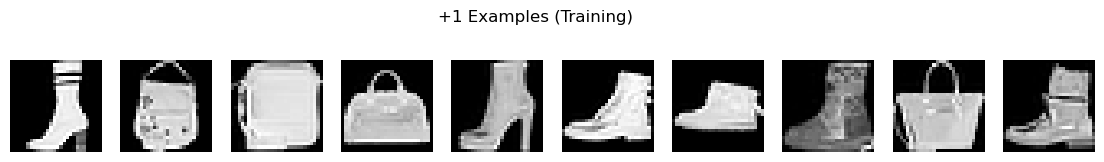

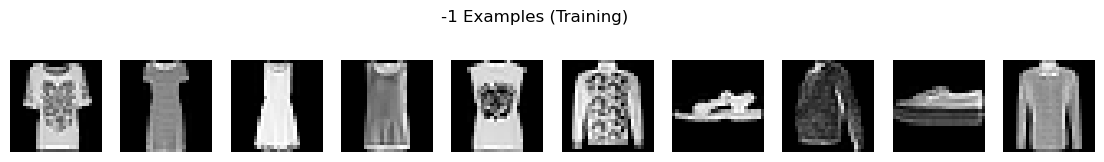

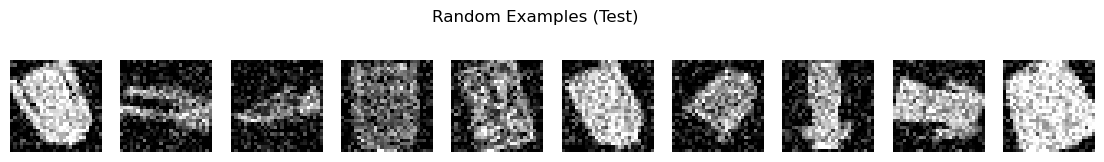

In [4]:
def get_random_samples(y, label, num_samples=10):
    #returns indicies of random samples from the given label
    indices = np.where(y == label)[0]
    return np.random.choice(indices, size=num_samples, replace=False)

def display_images(X, indices, title, image_shape=(28, 28)):
    num_images = len(indices)
    plt.figure(figsize=(14, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        # Using plt.matshow to display the reshaped image
        plt.matshow(X[idx].reshape(image_shape), cmap='gray', fignum=False)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 10 random examples for each class in the training data.
positive_samples = get_random_samples(ytrain, label=1, num_samples=10)
negative_samples = get_random_samples(ytrain, label=-1, num_samples=10)

# Images for the +1 class
display_images(Xtrain, positive_samples, "+1 Examples (Training)")

# Images for the -1 class
display_images(Xtrain, negative_samples, "-1 Examples (Training)")

# Random images from the test set 
test_samples = np.random.choice(Xtest.shape[0], size=10, replace=False)
display_images(Xtest, test_samples, "Random Examples (Test)")


- The (+1) images mainly consist of boots and handbags/purses, with clear outlines and consistent orientation. The (-1) images include T-shirts, sweatshirts, trainers and other clothing items, all generally well-centred and upright with recognisable details. Overall, both classes in the training set are neatly framed and visually distinct, which should make classification more straightforward.

- The test images appear grainier and potentially more distorted or rotated compared to the training examples. They vary in angle and have noisier backgrounds, which could challenge a model trained on cleaner, more uniformly oriented images. This suggests a need for preprocessing the images or to have a more sophisticated feature extraction method.

### **Accuracy**
$$
\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Number of Samples}}
$$
- Simple to calculate and interpret, but can misleading for imbalanced datasets.

### **Precision & Recall**
- **Precision:**  

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$
- **Recall**: 

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

### **AUC-ROC**
- **ROC Curve:** Plots the True Positive Rate (recall) against the False Positive Rate at various classification thresholds.
- **AUC-ROC:** This the area under the ROC curve. Ranges from 0.0 to 1.0, with 1.0 indicating a perfect classifier.

- AUC-ROC is a strong measure of a model’s ability to distinguish between classes, independent of a specific threshold. However, it can be affected by class imbalance and does not account for the relative costs of different types of errors.

### **AUC-PR**
- **Precision-Recall Curve:** Plots precision vs. recall at various thresholds.
- **AUC-PR:** The area under this precision-recall curve.

- AUC-PR is often more informative than ROC for imbalanced datasets as it focuses on positive predictions.

### **F1 Score**
$$
\text{F1} = 2 \times \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$
- Useful when you want an overall balance between precision and recall, especially in imbalanced datasets. However, because it combines precision and recall into a single value it can obscure whether issues lie more with precision or recall.


### **Matthews Correlation Coefficient (MCC)**
$$
\text{MCC} = \frac{(\text{TP} \times \text{TN}) - (\text{FP} \times \text{FN})}{\sqrt{(\text{TP}+\text{FP}) (\text{TP}+\text{FN}) (\text{TN}+\text{FP}) (\text{TN}+\text{FN})}}
$$
Where TP (True Positives), TN (True Negatives), FP (False Positives) and FN (False Negatives).
- Takes both classes’ predictions into account, robust to class imbalance and provides a single-figure measure of performance.

### **Mean Squared Error (MSE)**
The average of the squared differences between predicted and actual values
$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y_i} - y_i)^2
$$

### **Peformance Metric**


- Assuming the data is generally distributed like the test data, a classifier that performs well on imbalanced datasets would be most suitable, particularly when the positive class is less prevalent than the negative class. Suitable candidates from the list would be AUC-PR, F1 and MCC, as they are better suited for handling class imbalance compared to accuracy or AUC-ROC. 

- However, I think AUC-PR would be the most appropriate choice, as it focuses on the model’s ability to correctly classify the minority class without being influenced by the abundance of true negatives. Alternatively, MCC could be also be a strong option.

In [5]:
# Simulating a random classifier: assigns -1 or +1 with equal probability
random_predictions = np.random.choice([-1, 1], size=ytrain.shape)

# Compute accuracy
random_accuracy = np.mean(random_predictions == ytrain)

print(f"Accuracy on training data: {random_accuracy:.5f}")

Accuracy on training data: 0.49133


If the classes are evenly split (50/50), a random classifier assigning labels with equal probability (-1 or +1) would be expected to achieve 50% accuracy, as it will always guess correctly about half the time. However, if the dataset is imbalanced, the random classifier will naturally favor the majority class, leading to an accuracy that reflects its proportion in the data. Since there is no test labels, we cannot compute accuracy on the test set through a code experiment, but the same principle would apply.

In [6]:
# Convert labels to binary labels:
ytrain_bin = (ytrain == 1).astype(int)

# Generate random scores in [0, 1]
random_scores = np.random.rand(len(ytrain_bin))

# Compute AUC-ROC
auc_roc = roc_auc_score(ytrain_bin, random_scores)
print(f"Random classifier AUC-ROC (train): {auc_roc:.5f}")

# Compute AUC-PR
auc_pr = average_precision_score(ytrain_bin, random_scores)
print(f"Random classifier AUC-PR (train):  {auc_pr:.5f}")

Random classifier AUC-ROC (train): 0.48398
Random classifier AUC-PR (train):  0.19611


For a random classifier, the AUC-ROC is expected to be around 0.5, meaning it has no real ability to distinguish between classes and performs no better than random chance. This aligns with the result observed in the code, which fluctuates around 0.5. The AUC-PR, however is lower than AUC-ROC and depends on class imbalance. In this case, the AUC-PR of $\approx 0.2$ suggests that due to a class imbalance, the random classifier does not effectively prioritise positive samples. This aligns with the fact that the baseline precision for a random model is approximately equal to the positive class proportion in the dataset (~20%). This highlights that while AUC-ROC remains stable regardless of class distribution, AUC-PR is more sensitive to imbalance, making it a better metric when the positive class is rare.

In [7]:
knn = KNeighborsClassifier(n_neighbors=5)

skf = StratifiedKFold(n_splits=5, shuffle=True)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'auc_roc': make_scorer(roc_auc_score, needs_proba=True),
    'auc_pr': make_scorer(average_precision_score, needs_proba=True),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef)
}

# Perform cross-validation with stratified folds
cv_results = cross_validate(knn, Xtrain, ytrain, cv=skf, scoring=scoring, return_train_score=False)

# Convert results to DataFrame, we don't need the times so we can drop them.
results_df = pd.DataFrame(cv_results).drop(columns=['fit_time', 'score_time'])

# Compute mean and standard deviation
summary_df = results_df.agg(['mean', 'std']).T  

# Display results
display(summary_df)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


,mean,std
test_accuracy,0.965333,0.004625
test_balanced_accuracy,0.944352,0.007144
test_auc_roc,0.974349,0.006621
test_auc_pr,0.938249,0.013641
test_f1,0.914779,0.011128
test_mcc,0.893064,0.014033


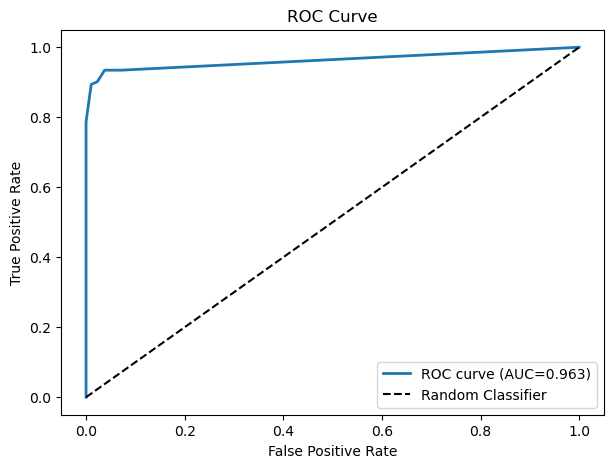

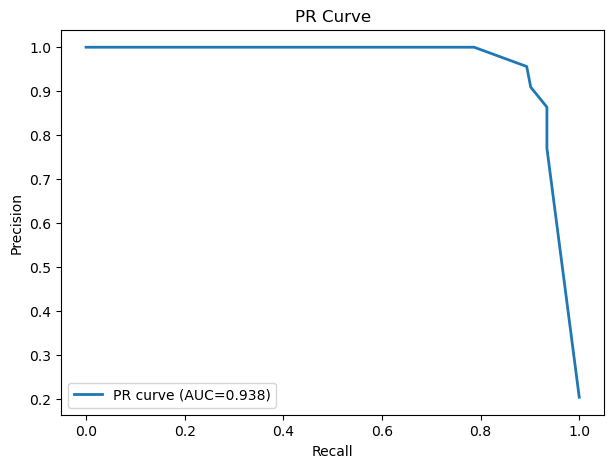

In [8]:
X = Xtrain  
y = ytrain  

skf = StratifiedKFold(n_splits=5, shuffle=True)
train_idx, val_idx = next(iter(skf.split(X, y)))  # Just taking the first fold

X_tr, X_val = X[train_idx], X[val_idx]
y_tr, y_val = y[train_idx], y[val_idx]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_tr)

# Predict probabilities of the positive class
y_prob = knn.predict_proba(X_val)[:, 1]

# Compute metrics
auc_roc = roc_auc_score(y_val, y_prob)
auc_pr  = average_precision_score(y_val, y_prob)

# Calculate coordinates for ROC/PR curve (third return is thresholds)
fpr, tpr, _ = roc_curve(y_val, y_prob)

precision, recall, _ = precision_recall_curve(y_val, y_prob)

# ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={auc_roc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# PR
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR curve (AUC={auc_pr:.3f})", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.legend(loc="lower left")
plt.show()

- The ROC curve shows a near-perfect performance, indicating that the classifier is highly effective at distinguishing between positive and negative classes. The curve stays close to the top-left corner, so it achieves a high true positive rate with a low false positive rate. The PR curve also demonstrates good performance, with an AUC-PR slightly smaller then the AUC-ROC. The curve remains nearly flat at high precision values before dropping sharply at high recall, indicating that the classifier is confident in its positive predictions.

- For this problem, the most important part of the ROC curve is the left-hand region, where the false positive rate is low. The classifier's ability to stay near the top-left suggests that it can detect positive cases effectively without misclassifying too many negatives. ROC curves can be misleading in imbalanced scenarios because a high true negative rate can inflate the AUC-ROC score. The fact that the PR curve stays at high precision for most recall values suggests that the model is handling the imbalance well.


### **Process**

- The model selection evaluates four classifiers: SVM with linear, polynomial and RBF kernels, along with Random Forest. Each SVM model is optimised for different kernel types, tuning parameters such as C, gamma and degree (for polynomial). The Random Forest classifier is optimised based on the number of trees and depth of the trees.

- To compare performance, we track six key metrics: accuracy, balanced accuracy, AUC-ROC, AUC-PR, F1 score, and MCC. AUC-PR is the primary metric for model selection since it provides better insight into performance on imbalanced data. If two models have similar AUC-PR scores, MCC and balanced accuracy are used as tie-breakers.

- Preprocessing is handled by standardisation to ensure fair comparisons, particularly for SVM models that rely on feature scaling. RandomizedSearchCV is used for hyperparameter tuning, as it is more efficient alternative to grid search. Five-fold stratified cross-validation ensures class balance within each fold.

- Once cross-validation is done, the mean and standard deviation of each metric are analysed. A model that achieves the highest AUC-PR while maintaining stable performance across folds is preferred. 



In [20]:
# Define classifiers and paramter distributions 
classifiers = [ 
    # loguniform and randint to randomly sample hyperparameters in RandomizedSearchCV
    (   
        "svm_linear",
        SVC(probability=True),
        {
            "svm_linear__C": loguniform(1e-3, 1e3),  
            "svm_linear__kernel": ["linear"]
        }
    ),
    (
        "svm_poly",
        SVC(probability=True),
        {
            "svm_poly__C": loguniform(1e-3, 1e3),
            "svm_poly__kernel": ["poly"],
            "svm_poly__degree": randint(2, 5),    
            "svm_poly__gamma": ["scale", "auto"]
        }
    ),
    (
        "svm_rbf",
        SVC(probability=True),
        {
            "svm_rbf__C": loguniform(1e-3, 1e3),
            "svm_rbf__kernel": ["rbf"],
            "svm_rbf__gamma": loguniform(1e-4, 1e0)  
        }
    ),
    (
        "randomforest",
        RandomForestClassifier(),
        {
            "randomforest__n_estimators": randint(50, 301),  
            "randomforest__max_depth": randint(5, 30)
        }
    )
]

# Metrics to be tracked
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'auc_roc': make_scorer(roc_auc_score, needs_proba=True),
    'auc_pr': make_scorer(average_precision_score, needs_proba=True),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef)
}

main_metric = 'auc_pr' # Used for optimising

skf = StratifiedKFold(n_splits=5, shuffle=True)

N_ITER = 15  # number of random parameter samples for each classifier
results_list = []

for name, base_clf, param_dist in classifiers:
    # Creating a pipeline
    pipe = Pipeline([
        ("scaler", MinMaxScaler()),       # pre-processing data, MinMax being a better choice over standard
        (name, base_clf)
    ])

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=N_ITER,
        scoring=scoring,
        refit=main_metric,         # Optimise on AUC-PR
        cv=skf,
        n_jobs=-1,           # parallelisation
        verbose=1,
        return_train_score=True
    )

    random_search.fit(Xtrain, ytrain)
    
    # Record results
    best_idx = random_search.best_index_
    mean_scores = {
        metric: random_search.cv_results_[f'mean_test_{metric}'][best_idx]
        for metric in scoring.keys()
    }
    
    results_list.append({
        "Model": name,
        "BestParams": random_search.best_params_,
        "BestEstimator": random_search.best_estimator_,  # store the pipeline
        **mean_scores
    })

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [ ]:
results_df = pd.DataFrame(results_list)

cross_validation_df = results_df.drop(columns=['BestParams', 'BestEstimator'])
display(cross_validation_df)

# Seperate table for better visualisation 
best_params_df = results_df[['Model', 'BestParams']].copy()
display(best_params_df)

# Adjusting Pandas display settings to show full results
pd.set_option('display.max_colwidth', None)  # Ensures full text is shown
pd.set_option('display.expand_frame_repr', False)  # Prevents column wrapping



,Model,accuracy,balanced_accuracy,auc_roc,auc_pr,f1,mcc
0,svm_linear,0.957000,0.925845,0.987708,0.958253,0.892165,0.866037
1,svm_poly,0.968000,0.938762,0.988561,0.965122,0.919093,0.900050
2,svm_rbf,0.974000,0.958866,0.992714,0.981383,0.936355,0.920133
3,randomforest,0.970667,0.947718,0.992685,0.980208,0.926564,0.909192


,Model,BestParams
0,svm_linear,"{'svm_linear__C': 0.020946411825918314, 'svm_linear__kernel': 'linear'}"
1,svm_poly,"{'svm_poly__C': 582.8242314993471, 'svm_poly__degree': 3, 'svm_poly__gamma': 'auto', 'svm_poly__kernel': 'poly'}"
2,svm_rbf,"{'svm_rbf__C': 66.88156071311066, 'svm_rbf__gamma': 0.012116962167002938, 'svm_rbf__kernel': 'rbf'}"
3,randomforest,"{'randomforest__max_depth': 28, 'randomforest__n_estimators': 206}"


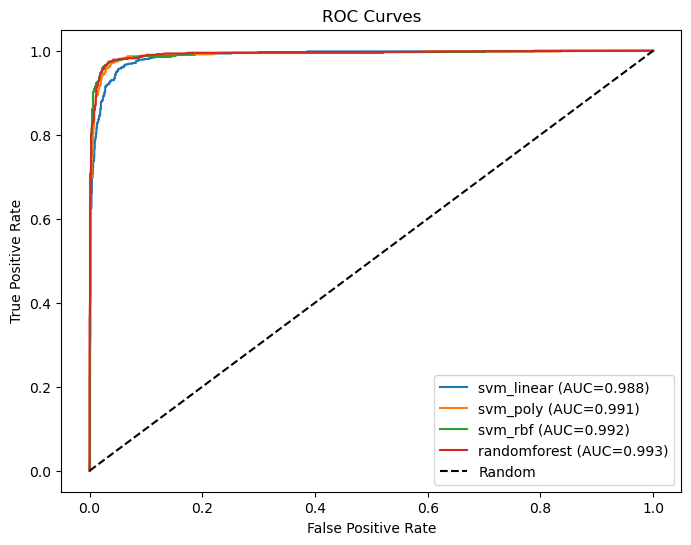

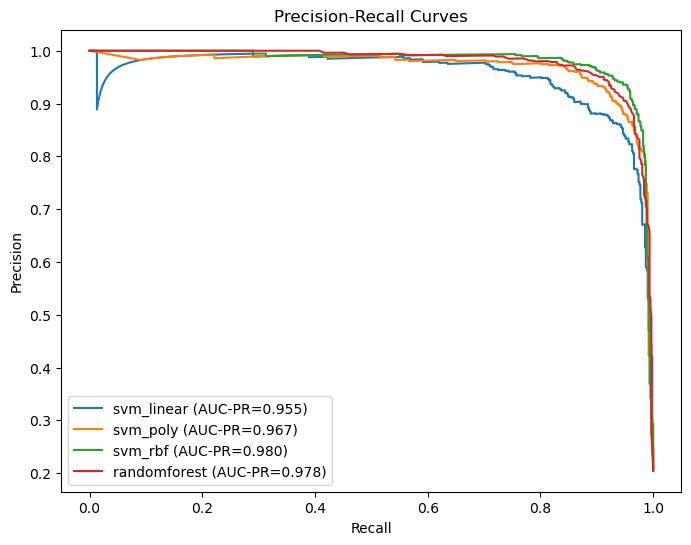

In [30]:
plt.figure(figsize=(8, 6))
for entry in results_list:
    model_name = entry["Model"]
    best_pipeline = entry["BestEstimator"]  # Pipeline(scaler, classifier)
    
    # predicted probabilities for the positive class from the best pipeline
    y_prob = cross_val_predict(best_pipeline, X, y, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]
    
    fpr, tpr, _ = roc_curve(y, y_prob)
    auc_roc = roc_auc_score(y, y_prob)
    
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_roc:.3f})")

# Random Classifier plot
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 6))
for entry in results_list:
    model_name = entry["Model"]
    best_pipeline = entry["BestEstimator"]
    
    y_prob = cross_val_predict(best_pipeline, X, y, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y, y_prob)
    auc_pr = average_precision_score(y, y_prob)
    
    plt.plot(recall, precision, label=f"{model_name} (AUC-PR={auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left")
plt.show()

Results indicate strong performance across all models, with SVM (RBF) and Random Forest achieving the highest AUC-ROC and AUC-PR scores. 

- The SVM (RBF) and Random Forest models perform similarly, maintaining high true positive rates across all thresholds. However, the PR curves highlight more noticeable differences. While all classifiers maintain high precision across most recall values, the Random Forest model slightly outperforms the others in AUC-PR. 

- Looking at the graph more closely, the RBF SVM (green) achieves higher precision across recall levels, indicating superior ranking of positive samples. Despite similar AUC-PR, it demonstrates slightly stronger performance in distinguishing between classes.

- The linear SVM, while still strong, shows a more noticeable decline in precision at higher recall values, suggesting it may struggle more with borderline cases. 



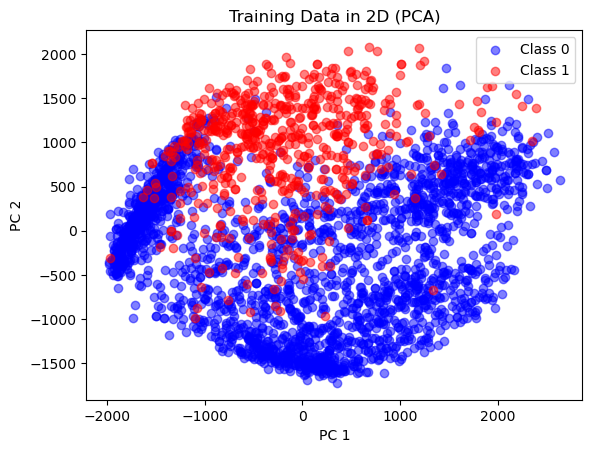

In [ ]:
pca = PCA(n_components=2)

ytrain_01 = (ytrain + 1)//2  # Negative class -> 0, Positive class -> 1

Xtrain_pca = pca.fit_transform(Xtrain) 

plt.scatter(
    Xtrain_pca[ytrain_01==0, 0], 
    Xtrain_pca[ytrain_01==0, 1],
    alpha = 0.5,      # Helps the visual as alpha controls transparancy 
    label="Class 0",
    color="blue"
)
plt.scatter(
    Xtrain_pca[ytrain_01==1, 0], 
    Xtrain_pca[ytrain_01==1, 1],
    alpha = 0.5,
    label="Class 1",
    color="red"
)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Training Data in 2D (PCA)")
plt.legend()
plt.show()

In the scatter plot, class 0 (blue) and class 1 (red) show some degree of separation but also significant overlap.

- There is some clustering of class 1 in the upper region and class 0 in the lower region. However, the classes are not perfectly separable, suggesting that PCA alone may not be enough for a clear class distinction.
- A large number of class 0 points are spread across the space, possibly due to class imbalance. The overlapping regions indicate that simple linear classifiers may not be that good at separating the classes effectively.
- PCA preserves variance but doesn't guarantee class separation, so higher-dimensional features may be more informative.



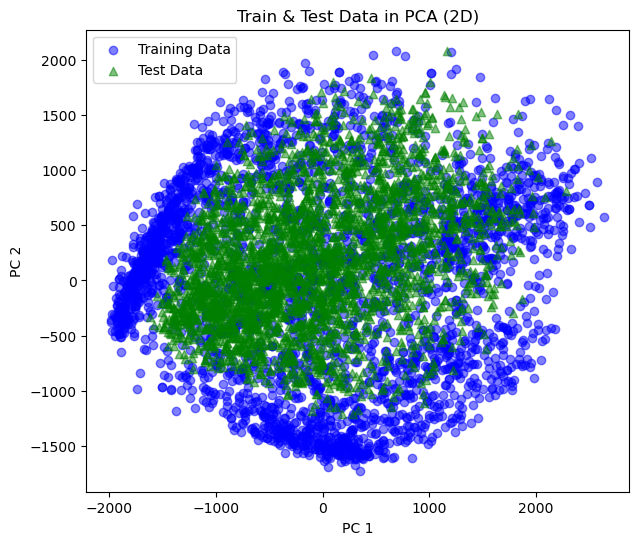

In [13]:
pca = PCA(n_components=2)

Xtrain_pca = pca.fit_transform(Xtrain)  

Xtest_pca  = pca.transform(Xtest)     

plt.figure(figsize=(7, 6))

plt.scatter(
    Xtrain_pca[:, 0], 
    Xtrain_pca[:, 1],
    alpha=0.5, 
    color='blue', 
    marker='o', 
    label='Training Data'
)
plt.scatter(
    Xtest_pca[:, 0], 
    Xtest_pca[:, 1],
    alpha=0.5, 
    color='green', 
    marker='^', 
    label='Test Data'
)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Train & Test Data in PCA (2D)")
plt.legend()
plt.show()

The test data (green triangles) is largely overlapping with the training data (blue circles), indicating that the overall distribution of both sets is similar. 

- Some test points extend beyond the training cluster, suggesting distribution shifts that could affect generalisation. While the overlap indicates the model can learn patterns, unseen variations may require preprocessing.

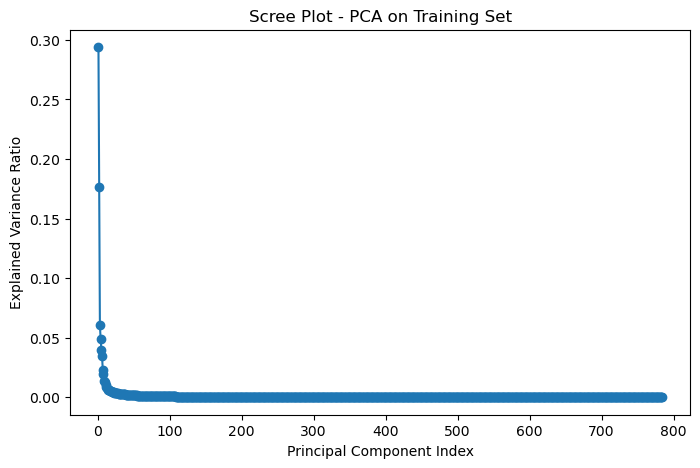

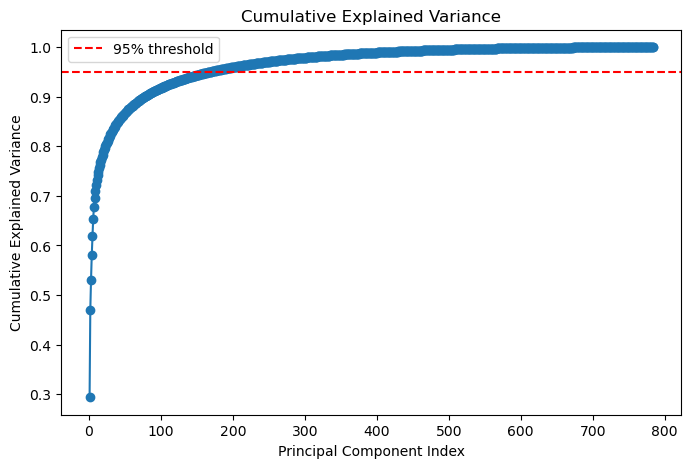

Number of components needed for >=95% variance: 168


In [31]:
pca_full = PCA()  # keep all principal components 
pca_full.fit(Xtrain)

# variance ratio per component
variance_ratios = pca_full.explained_variance_ratio_  

# scree graph: variance ratio vs. component index
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(variance_ratios)+1), variance_ratios, marker='o')
plt.title("Scree Plot - PCA on Training Set")
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.show()

cumulative_variance = np.cumsum(variance_ratios) 
dims_95 = np.searchsorted(cumulative_variance, 0.95) + 1  # +1 because index is 0-based

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
plt.title("Cumulative Explained Variance")
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.show()

print(f"Number of components needed for >=95% variance: {dims_95}")

In [50]:
# Include PCA in the pipeline
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA()), 
    ("svc", SVC(kernel="rbf", probability=True))  # using the rbf kernal for the SVM 
])

param_distributions = {
    "pca__n_components": randint(20,201),  
    "svc__C": loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-3, 1)  
}

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "auc_roc": make_scorer(roc_auc_score, needs_proba=True),
    "auc_pr": make_scorer(average_precision_score, needs_proba=True),
    "f1": make_scorer(f1_score)
}

main_metric = "auc_pr"  
skf = StratifiedKFold(n_splits=5, shuffle=True)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,             # number of random draws
    scoring=scoring,
    refit=main_metric,     # the metric to select best params & refit with
    cv=skf,
    n_jobs=-1,             # parallelise       
    verbose=1
)

random_search.fit(Xtrain, ytrain)

# results
print(f"Best params (by {main_metric}):", random_search.best_params_)
print(f"Best {main_metric} score:", random_search.best_score_)

cv_results_df = pd.DataFrame(random_search.cv_results_)

best_index = random_search.best_index_  # Index of the best model
best_scores = {
    "Best Accuracy": cv_results_df.iloc[best_index]["mean_test_accuracy"],
    "Best Balanced Accuracy": cv_results_df.iloc[best_index]["mean_test_balanced_accuracy"],
    "Best AUC-ROC": cv_results_df.iloc[best_index]["mean_test_auc_roc"],
    "Best F1 Score": cv_results_df.iloc[best_index]["mean_test_f1"]
}

display(best_scores)


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params (by auc_pr): {'pca__n_components': 134, 'svc__C': 14.568179085716817, 'svc__gamma': 0.04663970087915474}
Best auc_pr score: 0.9858138773952831


{'Best Accuracy': 0.9766666666666666,
 'Best Balanced Accuracy': 0.9581290889168749,
 'Best AUC-ROC': 0.9938553173592102,
 'Best F1 Score': 0.9421139215054047}

- This pipeline transforms the original labels \([-1,+1]\) to \([0,1]\), then processes the data through a MinMaxScaler (scaling features to 0–1) and PCA. Finally, an RBF-kernel SVC is trained as this was the best model, with probability outputs for calculating AUC-PR. 

- RandomizedSearchCV explores different hyperparameters: how many principal components to keep and the SVM’s C and gamma. Using 5-fold stratified CV, it selects the combination that maximises average precision. After refitting on the entire training set, the final model yields probability scores for each test sample.

In [56]:
ytrain_adj = (ytrain + 1)//2

pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA()), 
    ("svc", SVC(kernel="rbf", probability=True))
])

param_distributions = {
    "pca__n_components": randint(20, 201),
    "svc__C": loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-3, 1)
}

scoring = {
    "auc_pr": make_scorer(average_precision_score, needs_proba=True),
}

main_metric = "auc_pr"
skf = StratifiedKFold(n_splits=5, shuffle=True)

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=25,           
    scoring=scoring,
    refit=main_metric,   
    cv=skf,
    verbose=1,
    n_jobs=-1,
)

random_search.fit(Xtrain, ytrain_adj)

print("Best parameters:", random_search.best_params_)
print(f"Best {main_metric} score:", random_search.best_score_)

# Retrieve the best pipeline, already fit on the full train set
best_model = random_search.best_estimator_

# Probility scores output
test_scores = best_model.predict_proba(Xtest)[:, 1] 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best parameters: {'pca__n_components': 132, 'svc__C': 6.153663045571794, 'svc__gamma': 0.03648378603344573}
Best auc_pr score: 0.9865664644176867


In [ ]:
# For storing prediction scores
scores_filename = "/Users/akrambellala/Desktop/scores.csv"  
pd.DataFrame(test_scores).to_csv(scores_filename, index=False, header=False)
print(f"Test probability scores saved to {scores_filename}")

In [ ]:
N_train = len(Xtrain)
N_test  = len(Xtest)

X_combined = np.vstack([Xtrain, Xtest])   
y_combined = np.concatenate([
    np.full(N_train, -1),  # label all train examples as -1
    np.full(N_test,  +1)   # label all test examples as +1
])

pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svc", SVC(kernel="rbf", probability=True))
])

param_distributions = {
    "svc__C":     loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-4, 1e0),
}

auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

skf = StratifiedKFold(n_splits=5, shuffle=True)

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=5,              
    scoring=auc_scorer,     
    refit=True,             # refit best model on entire dataset
    cv=skf,
    n_jobs=-1,
    verbose=1,
)

random_search.fit(X_combined, y_combined)

print("Best Params:", random_search.best_params_)

best_mean_auc = random_search.best_score_
print(f"Mean AUC-ROC: {best_mean_auc:.4f}")

best_idx = random_search.best_index_
best_std_auc = random_search.cv_results_["std_test_score"][best_idx]
print(f"Std AUC-ROC: {best_std_auc:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Params: {'svc__C': 196.236157699769, 'svc__gamma': 0.00032286602228204095}
Mean AUC-ROC: 0.9994
Std AUC-ROC: 0.0006


The classifier achieves AUC-ROC ≈ 0.99, indicating nearly perfect separation between training (-1) and test (+1) samples. A random classifier would score around 0.5, so an AUC near 1.0 strongly suggests a systematic distribution difference, where the model easily distinguishes train from test data. 

- This implies that certain features in the training set differ significantly from those in the test set, allowing the SVM to separate them.

You can identify systematic differences by analysing feature distributions, such as comparing the mean and variance across training and test sets. 

- If preprocessing steps differ between the train and test data, standardising them can help reduce discrepancies. Additionally, augmenting the training set with transformations like noise, rotations or scaling can make it more similar to the test set.

- After making adjustments and re-running the train-vs-test classification; if the AUC-ROC moves closer to 0.5, this indicates that the gap between the datasets has been minimised and the sets are no longer easily distinguishable.

/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (first half): {'svc__gamma': 0.03648378603344573, 'svc__C': 6.153663045571794, 'pca__n_components': 132}
Best auc_roc (first half): 0.9992
AUC on second half: 0.7670


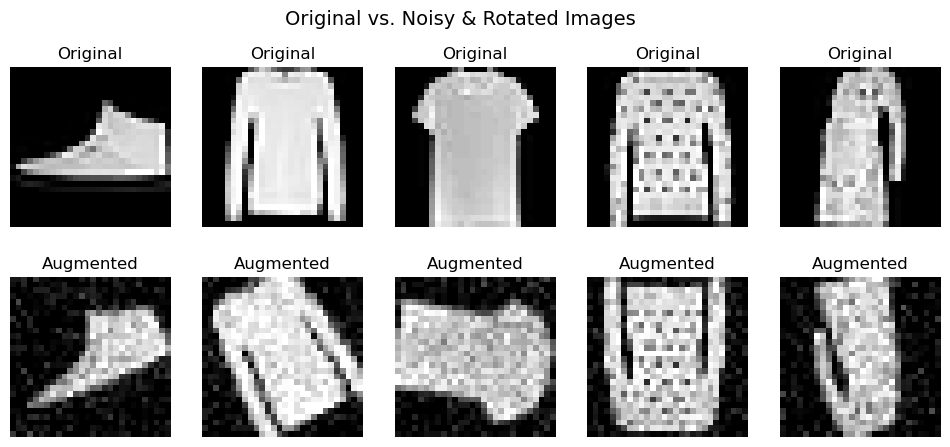

In [ ]:
# function to add noise and rotations 
def rotate_and_noise(X, image_shape=(28,28), max_angle=15, noise_std=0.1):
    X_out = []
    for x in X:
        img = x.reshape(image_shape)
        angle = np.random.uniform(-max_angle, max_angle) 
        rotated = rotate(img, angle, preserve_range=True)
        noisy = rotated + np.random.normal(loc=0.0, scale=noise_std, size=rotated.shape)
        noisy = np.clip(noisy, 0, 255)
        X_out.append(noisy.ravel()) 
    return np.array(X_out)

N_train = len(Xtrain)
N_test  = len(Xtest)

# Split train/test each in half 
half_train = N_train // 2
half_test  = N_test  // 2

Xtrain1 = Xtrain[:half_train]
Xtrain2 = Xtrain[half_train:]
Xtest1  = Xtest[:half_test]
Xtest2  = Xtest[half_test:]

ytrain1 = np.full(len(Xtrain1), -1)
ytest1  = np.full(len(Xtest1),  +1)

# Train classifier on optimal pipeline
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA()),
    ("svc", SVC(kernel="rbf", probability=True))
])


param_distributions = {
    "pca__n_components": [132], #randint(20, 201),
    "svc__C": [6.153663045571794], #loguniform(1e-3, 1e3),
    "svc__gamma": [0.03648378603344573] #loguniform(1e-3, 1e0)
}

scoring = {
    "auc_roc": make_scorer(average_precision_score, needs_proba=True)
}
main_metric = "auc_roc"

# Combine first-half data
Xcomb1 = np.vstack([Xtrain1, Xtest1])
ycomb1 = np.concatenate([ytrain1, ytest1])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=scoring,
    refit=main_metric,
    cv=skf,
    verbose=1,
    n_jobs=-1
)

random_search.fit(Xcomb1, ycomb1)
best_model = random_search.best_estimator_

print("Best params (first half):", random_search.best_params_)
print(f"Best {main_metric} (first half): {random_search.best_score_:.4f}")

# Transform the other half of training data 
Xtrain2_aug = rotate_and_noise(
    Xtrain2, 
    image_shape=(28,28), 
    max_angle=180,   
    noise_std=25.0  
)

ytrain2 = np.full(len(Xtrain2_aug), -1)
ytest2  = np.full(len(Xtest2),      +1)

# Test the same classifier on second half
Xcomb2 = np.vstack([Xtrain2_aug, Xtest2])
ycomb2 = np.concatenate([ytrain2, ytest2])

probs = clf.predict_proba(Xcomb2)[:, 1]  
auc_once = roc_auc_score(ycomb2, probs)
print(f"AUC on second half: {auc_once:.4f}")

# visualisation of the transformed images 
num_samples = 5  # Number of images to visualise
sample_indices = np.random.choice(len(Xtrain2), num_samples, replace=False)
Xtrain2_sample = Xtrain2[sample_indices]
Xtrain2_aug_sample = Xtrain2_aug[sample_indices]  # Use the same transformed data

# Plot original vs noisy images
fig, axes = plt.subplots(2, num_samples, figsize=(12, 5))

for i in range(num_samples):
    # Original image
    axes[0, i].imshow(Xtrain2_sample[i].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Noisy, rotated image
    axes[1, i].imshow(Xtrain2_aug_sample[i].reshape(28, 28), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Augmented")

plt.suptitle("Original vs. Noisy & Rotated Images", fontsize=14)
plt.show()

The dataset is split into two halves to test for domain shift. 

- On the first half, the optimal classifier is trained to determine if it can distinguish training from test samples. A high AUC indicates a systematic distribution difference.
 
- The second half is augmented with noise and rotations before being tested with second half of the test set. 

The high AUC on the first half confirms that the classifier can distinguish training from test samples, highlighting a strong systematic difference between the two sets. However, after adding noise and rotations to the second half, the AUC drops to a lower value. 

The augmentation process distorts images with noise and rotations, disrupting patterns the model initially relied on. The reduced AUC after augmentation indicates that these patterns were disrupted.